In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# Out Of Memory 문제 방지 (메모리 청소)

tf.keras.backend.clear_session()

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation 적용한 데이터셋 만들기

In [5]:
# data set 다운로드

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### Cutmix 구현하기

In [6]:
# num classes 변수 미리 지정
num_classes = ds_info.features["label"].num_classes

In [7]:
# 이미지 합성 범위 지정
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]          # width 추출
    image_size_y = image_a.shape[0]          # height 추출
    
    # x축, y축에서 지점 랜덤 선택
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)          
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # 난수와 width,height 활용하여 새로운 길이 생성 (사진 길이보다 작게)
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # 랜덤 선택 지점을 중점으로 width, height만큼 clip box 생성
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [8]:
# clip box 활용하여 2개의 이미지 섞기
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [9]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=num_classes):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)    # cutmix 비율 만큼 label mix

    # 원핫 인코딩 처리하기
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

In [10]:
# Cutmix 함수 구현

def cutmix(images, labels, img_size=224, batch_size=16, num_classes=num_classes):    
    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치에서 각 이미지와 라벨 추출
        image_a = images[i]
        label_a = labels[i]

        # 랜덤 인덱스 생성
        j = tf.random.uniform([], 0, batch_size, dtype=tf.int32)
        image_b = images[j]
        label_b = labels[j]

        # 클리핑 박스 계산
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        mixed_image = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_label = mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max)

        # 이미지와 라벨 혼합, 결과 리스트에 추가
        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)


    # 배치 크기에 맞게 텐서로 변환
    mixed_images = tf.reshape(tf.stack(mixed_images), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_images, mixed_labels

In [11]:
# function for mixup
def mixup(image, label, img_size=224, batch_size=16, num_classes=num_classes):
    
    ratio = tf.random.uniform([], 0, 1)

    mixed_images = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치에서 각 이미지와 라벨 추출
        image_a = image[i]
        label_a = label[i]
        # 랜덤 인덱스 생성
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]

        # 원핫 인코딩 처리하기
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        if len(label_b.shape)==0:
            label_b = tf.one_hot(label_b, num_classes)
           
        # 비율에 맞게 이미지와 라벨 혼합
        mixed_image= (1-ratio)*image_a + ratio*image_b
        mixed_label = (1-ratio)*label_a + ratio*label_b
        
        # 결과 리스트에 추가
        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)

    # 배치 크기에 맞게 텐서로 변환
    mixed_images = tf.reshape(tf.stack(mixed_images), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
        
    
    return mixed_images, mixed_labels

### 라벨을 원-핫 인코딩 형태로 처리하는 이유?  

(1) 클래스 간 비율 정보를 유지  
mixup에서는 두 개의 라벨을 섞을 때 클래스 간 비율 정보를 반영한다.  

<예시>  
- img_a : [1,0]
- img_b : [0,1]
- 혼합 비율 0.7
- 결과 : [0.7, 0.3]

In [12]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    # label을 정수형으로 변환
    label = tf.cast(label, tf.int32)
    
    label = tf.one_hot(label, num_classes)
    return image, label

# 메인함수
def apply_normalize_on_dataset(ds,is_test=False,batch_size=16,with_aug=False,with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=tf.data.experimental.AUTOTUNE   # 최적의 thread 찾기 AUTOTUNE
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    # CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    if not is_test:
        ds = ds.repeat()
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
# augmentation 적용하기
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

TypeError : missing 1 required positional argument: 'label'  
=> 데이터셋 다운로드 시, as_supervised=True로 설정

## 2. 모델 만들기

In [ ]:
# 1. 일반 데이터셋 용 모델

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 2. Augmentation 모델

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [30]:
# 3. Cutmix 모델

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [31]:
# 4. Mixup 모델

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 학습

일반 데이터셋 모델

In [32]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [ ]:
# EPOCH = 3

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

callbacks=tf.keras.callbacks.ModelCheckpoint(
    'history/resnet50.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[callbacks],
    verbose=1)

Augmentation 데이터셋 모델

In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

callbacks=tf.keras.callbacks.ModelCheckpoint(
    'history/aug_resnet50.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[callbacks],
    verbose=1)

Cutmix 데이터셋 모델

In [33]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

callbacks=tf.keras.callbacks.ModelCheckpoint(
    'history/cutmix_resnet50.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[callbacks],
    verbose=1)

Epoch 1/20
750/750 [==============================] - 201s 206ms/step - loss: 3.8116 - accuracy: 0.2173 - val_loss: 3.2224 - val_accuracy: 0.2229

Epoch 00001: val_loss improved from inf to 3.22240, saving model to history/cutmix_resnet50.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 2.9095 - accuracy: 0.4409 - val_loss: 1.3562 - val_accuracy: 0.6234

Epoch 00002: val_loss improved from 3.22240 to 1.35617, saving model to history/cutmix_resnet50.h5
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 2.5961 - accuracy: 0.5532 - val_loss: 1.3348 - val_accuracy: 0.6308

Epoch 00003: val_loss improved from 1.35617 to 1.33479, saving model to history/cutmix_resnet50.h5
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.3813 - accuracy: 0.6212 - val_loss: 1.3286 - val_accuracy: 0.6396

Epoch 00004: val_loss improved from 1.33479 to 1.32857, saving model to history/cutmix_resnet50.h5
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 2.2245 - accuracy: 0.6748 - val_loss: 1.3800 - val_accuracy: 0.6409

Epoch 00005: val_loss did not improve from 1.32857
Epoch 6/20
750/750 [==============================] - 155s 207ms

Mixup 데이터셋 모델

In [34]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

callbacks=tf.keras.callbacks.ModelCheckpoint(
    'history/mixup_resnet50.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[callbacks],
    verbose=1)

Epoch 1/20
750/750 [==============================] - 159s 207ms/step - loss: 3.6822 - accuracy: 0.2547 - val_loss: 4.5259 - val_accuracy: 0.0968

Epoch 00001: val_loss improved from inf to 4.52589, saving model to history/mixup_resnet50.h5
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 2.8084 - accuracy: 0.5128 - val_loss: 1.5072 - val_accuracy: 0.5928

Epoch 00002: val_loss improved from 4.52589 to 1.50720, saving model to history/mixup_resnet50.h5
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.4780 - accuracy: 0.6264 - val_loss: 1.5891 - val_accuracy: 0.5676

Epoch 00003: val_loss did not improve from 1.50720
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 2.3380 - accuracy: 0.6872 - val_loss: 1.3082 - val_accuracy: 0.6427

Epoch 00004: val_loss improved from 1.50720 to 1.30824, saving model to history/mixup_resnet50.h5
Epoch 5/20
750/750 [==============================] - 155s 206ms/step -

학습 후 히스토리 저장하기

In [40]:
# 히스토리 저장
import pandas as pd
import json

# with open('history/history_resnet50_no_aug.json', 'w') as f:
#     pd.DataFrame(history_resnet50_no_aug.history).to_json(f)

# with open('history/history_resnet50_aug.json', 'w') as f:
#     pd.DataFrame(history_resnet50_aug.history).to_json(f)

# with open('history/history_resnet50_cutmix.json', 'w') as f:
#     pd.DataFrame(history_resnet50_cutmix.history).to_json(f)

# with open('history/history_resnet50_mixup.json', 'w') as f:
#     pd.DataFrame(history_resnet50_mixup.history).to_json(f)


# with open('history/history_resnet50_cutmix_100.json', 'w') as f:
#     pd.DataFrame(history_resnet50_cutmix_100.history).to_json(f)

In [4]:
def history_conv(history):
    
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}
    
    return return_history

In [5]:
# 저장된 히스토리 불러오기
import pandas as pd
import json

with open('history/history_resnet50_no_aug.json', 'r') as f:
    history_resnet50_no_aug = json.load(f)
    

with open('history/history_resnet50_aug.json', 'r') as f:
    history_resnet50_aug = json.load(f)
    

with open('history/history_resnet50_cutmix.json', 'r') as f:
    history_resnet50_cutmix = json.load(f)
    
with open('history/history_resnet50_mixup.json', 'r') as f:
    history_resnet50_mixup = json.load(f)

history_resnet50_no_aug = history_conv(history_resnet50_no_aug)
history_resnet50_aug = history_conv(history_resnet50_aug)
history_resnet50_cutmix = history_conv(history_resnet50_cutmix)
history_resnet50_mixup = history_conv(history_resnet50_mixup)

## 4. 시각화 하기

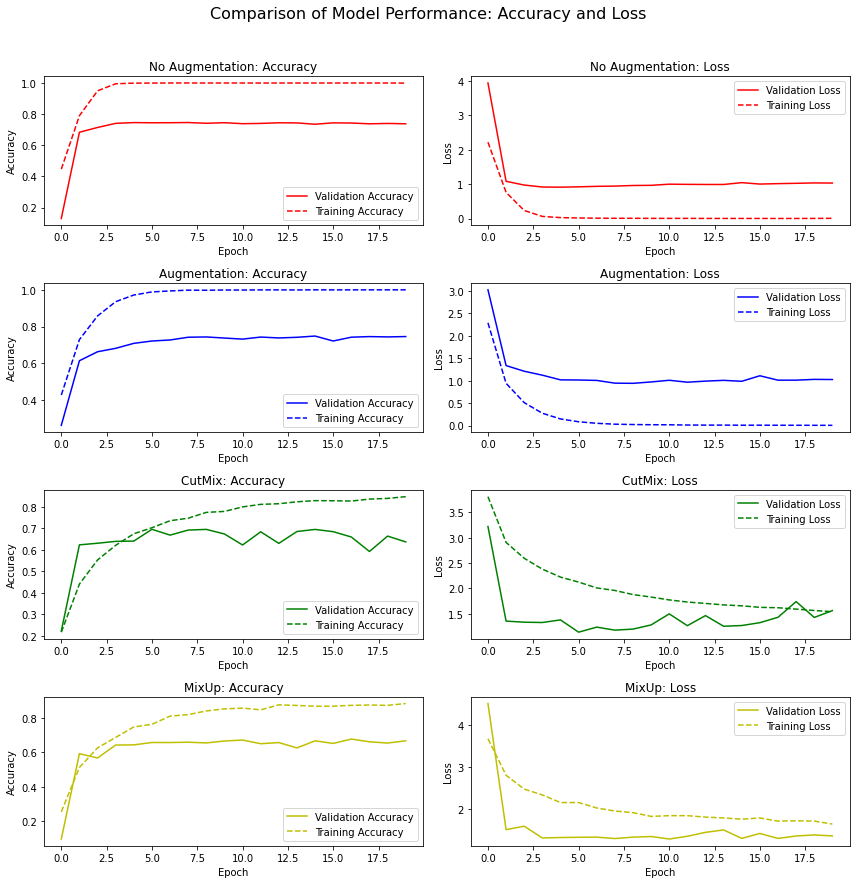

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))  # 전체 그래프 크기 조정

# 1. No Augmentation Accuracy
plt.subplot(4, 2, 1)
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='Validation Accuracy')
plt.plot(history_resnet50_no_aug['accuracy'], 'r--', label='Training Accuracy')
plt.title('No Augmentation: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 2. No Augmentation Loss
plt.subplot(4, 2, 2)
plt.plot(history_resnet50_no_aug['val_loss'], 'r', label='Validation Loss')
plt.plot(history_resnet50_no_aug['loss'], 'r--', label='Training Loss')
plt.title('No Augmentation: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 3. Augmentation Accuracy
plt.subplot(4, 2, 3)
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='Validation Accuracy')
plt.plot(history_resnet50_aug['accuracy'], 'b--', label='Training Accuracy')
plt.title('Augmentation: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 4. Augmentation Loss
plt.subplot(4, 2, 4)
plt.plot(history_resnet50_aug['val_loss'], 'b', label='Validation Loss')
plt.plot(history_resnet50_aug['loss'], 'b--', label='Training Loss')
plt.title('Augmentation: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 5. CutMix Accuracy
plt.subplot(4, 2, 5)
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g', label='Validation Accuracy')
plt.plot(history_resnet50_cutmix['accuracy'], 'g--', label='Training Accuracy')
plt.title('CutMix: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 6. CutMix Loss
plt.subplot(4, 2, 6)
plt.plot(history_resnet50_cutmix['val_loss'], 'g', label='Validation Loss')
plt.plot(history_resnet50_cutmix['loss'], 'g--', label='Training Loss')
plt.title('CutMix: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 7. MixUp Accuracy
plt.subplot(4, 2, 7)
plt.plot(history_resnet50_mixup['val_accuracy'], 'y', label='Validation Accuracy')
plt.plot(history_resnet50_mixup['accuracy'], 'y--', label='Training Accuracy')
plt.title('MixUp: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 8. MixUp Loss
plt.subplot(4, 2, 8)
plt.plot(history_resnet50_mixup['val_loss'], 'y', label='Validation Loss')
plt.plot(history_resnet50_mixup['loss'], 'y--', label='Training Loss')
plt.title('MixUp: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 전체 레이아웃 최적화 및 제목 설정
plt.suptitle('Comparison of Model Performance: Accuracy and Loss', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


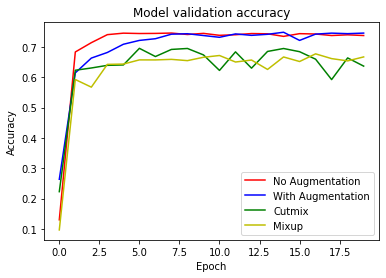

In [38]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','Cutmix', 'Mixup'], loc='best')
plt.show()

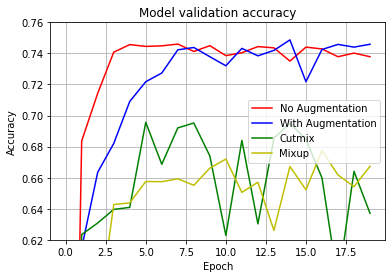

In [41]:
# 확대해보기
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','Cutmix', 'Mixup'], loc='best')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
plt.ylim(0.62, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

### 의문점  
cutmix와 mixup이 논문가 다르게 성능이 나쁜 이유가 뭘까?  
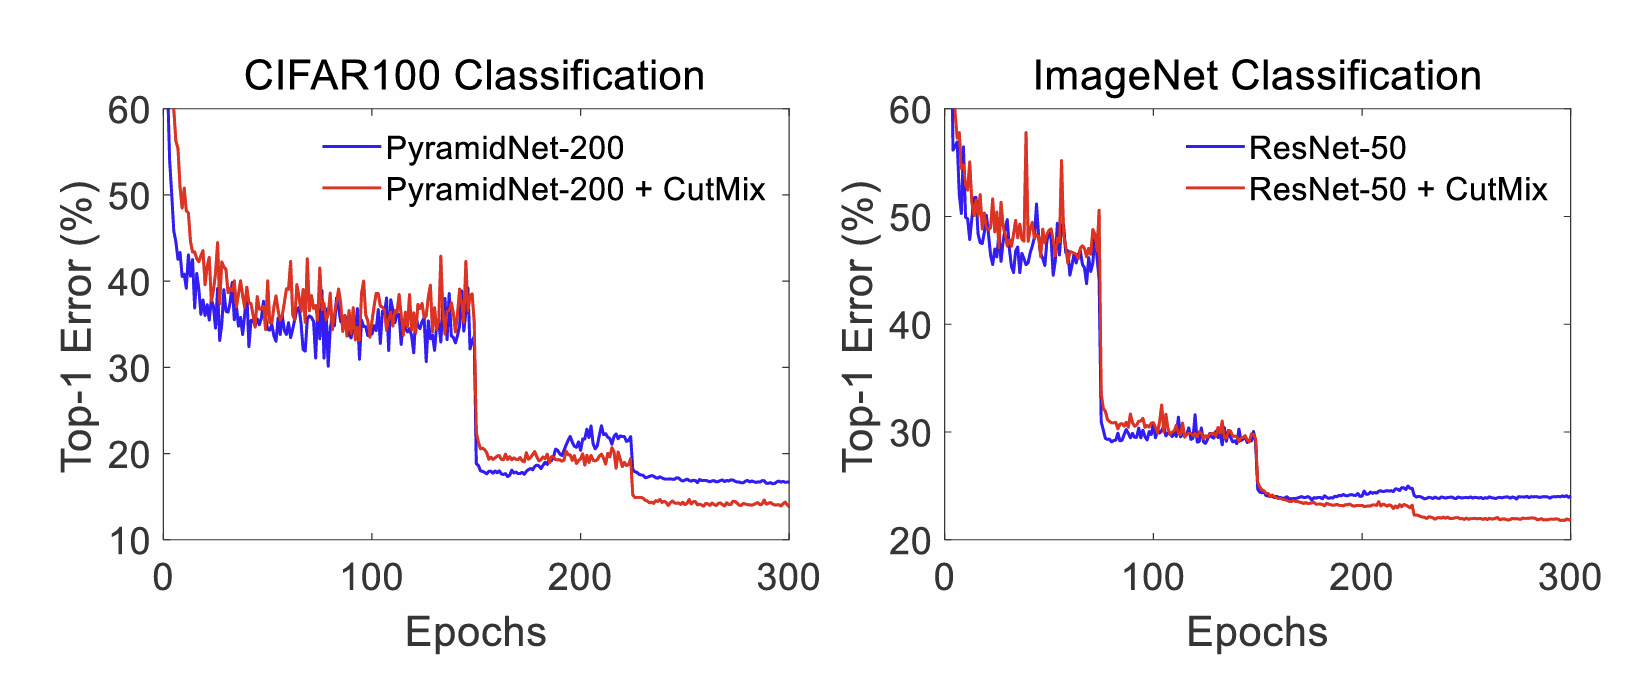  

논문의 사진을 봤을 때
epoch이 200이 넘어야 효과가 있는 거 아닐까 생각했다.

## + 추가실험  

퍼실님과 얘기를 했을 때, 컷믹스와 믹스업의 경향성을 보는 것이 더 중요하다고 판단했다.  
그래서 믹스업과 컷믹스의 에폭만 늘려서 실험을 진행하는 것과 테스트 데이터를 새로 다운 받아서 테스트 성능을 확인하는 실험하는 것으로 목표를 잡았다.

In [29]:
EPOCH = 100  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [30]:
# 3. Cutmix 모델

cutmix_resnet50_100 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [34]:
# 4. Mixup 모델

mixup_resnet50_100 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [35]:
cutmix_resnet50_100.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

callbacks=tf.keras.callbacks.ModelCheckpoint(
    'history/cutmix_resnet50_100.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

history_resnet50_cutmix_100 = cutmix_resnet50_100.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    callbacks=[callbacks],
    verbose=1)

Epoch 1/100
750/750 [==============================] - 163s 213ms/step - loss: 3.8459 - accuracy: 0.2050 - val_loss: 3.7361 - val_accuracy: 0.1709

Epoch 00001: val_loss improved from inf to 3.73607, saving model to history/cutmix_resnet50_100.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
750/750 [==============================] - 159s 212ms/step - loss: 2.9314 - accuracy: 0.4398 - val_loss: 1.3922 - val_accuracy: 0.6034

Epoch 00002: val_loss improved from 3.73607 to 1.39223, saving model to history/cutmix_resnet50_100.h5
Epoch 3/100
750/750 [==============================] - 159s 212ms/step - loss: 2.6151 - accuracy: 0.5358 - val_loss: 1.2139 - val_accuracy: 0.6554

Epoch 00003: val_loss improved from 1.39223 to 1.21388, saving model to history/cutmix_resnet50_100.h5
Epoch 4/100
750/750 [==============================] - 159s 212ms/step - loss: 2.4135 - accuracy: 0.6097 - val_loss: 1.1867 - val_accuracy: 0.6725

Epoch 00004: val_loss improved from 1.21388 to 1.18671, saving model to history/cutmix_resnet50_100.h5
Epoch 5/100
750/750 [==============================] - 159s 212ms/step - loss: 2.2464 - accuracy: 0.6644 - val_loss: 1.2097 - val_accuracy: 0.6701

Epoch 00005: val_loss did not improve from 1.18671
Epoch 6/100
750/750 [===========================

KeyboardInterrupt: 

In [ ]:
# # 50번 더 추가학습

# history_resnet50_cutmix_150_ = cutmix_resnet50_100.fit(
#     ds_train_cutmix,  # 기존 데이터셋 유지
#     steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
#     validation_steps=int(ds_info.splits['test'].num_examples / 16),
#     epochs=150,  # 총 150 epochs까지 학습
#     initial_epoch=75,  # 이전 학습이 끝난 epoch를 기준으로 시작
#     validation_data=ds_test,
#     callbacks=[callbacks],
#     verbose=1
# )

In [ ]:
# # 히스토리 병합

# def merge_history(prev_history, new_history):
#     for key in prev_history:
#         prev_history[key].extend(new_history[key])
#     return prev_history
    
    
# history_combined = merge_history(
#     history_resnet50_cutmix_100.history,
#     history_resnet50_cutmix_150.history
# )

In [ ]:
# mixup_resnet50_100.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
#     metrics=['accuracy'],
# )

# callbacks=tf.keras.callbacks.ModelCheckpoint(
#     'history/mixup_resnet50_100.h5',
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True)

# history_resnet50_100_mixup = mixup_resnet50_100.fit(
#     ds_train_mixup, # mixup 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     callbacks=[callbacks],
#     verbose=1)

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))  # 전체 그래프 크기 조정

# 1. CutMix Accuracy
plt.subplot(2, 1, 1)
plt.plot(history_resnet50_cutmix_100['val_accuracy'], 'g', label='Validation Accuracy')
plt.plot(history_resnet50_cutmix_100['accuracy'], 'g--', label='Training Accuracy')
plt.title('CutMix: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# 2. CutMix Loss
plt.subplot(2, 1, 2)
plt.plot(history_resnet50_cutmix_100['val_loss'], 'g', label='Validation Loss')
plt.plot(history_resnet50_cutmix_100['loss'], 'g--', label='Training Loss')
plt.title('CutMix: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 전체 레이아웃 최적화 및 제목 설정
plt.suptitle('Comparison of Model Performance: Accuracy and Loss', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 회고

팀원들과 실험을 진행하기 위해서 끝까지 결과를 볼 수 없었지만 20 epoch까지 돌려봤을 때  
cutmix와 mixup 의 train data가 조금 더 학습이 가능한 상태로 보여졌다.
팀원들과 수업이 끝난 후 epoch 수를 늘려서 각자 하나씩 모델을 돌려본 후 결과를 비교해볼 예정이다.  
학습을 통해 결과를 아는 것도 중요하지만 먼저 데이터를 돌려보고 그 이후에 어떤 것을 실행해야 할 지 결정하는 능력도 중요하다는 것을 알았다.
epoch 수를 높여서 실험해봤을 때, 현재 결과보다 발전된 결과를 볼 수 있었으면 좋겠다!